In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
6
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling',
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling',
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        CoExpression           PCC           PPI  Root10DaysSeedling  \
count  41110.000000  41110.000000  41110.000000        41110.000000   
mean       0.991997     -0.361737      0.914668           -0.522040   
std        0.089101      0.463979      0.279379            0.498568   
min        0.000000     -1.000000      0.000000           -1.000000   
25%        1.000000     -0.747963      1.000000           -0.901371   
50%        1.000000     -0.449089      1.000000           -0.663664   
75%        1.000000     -0.051646      1.000000           -0.378497   
max        1.000000      1.000000      1.000000            1.000000   

       Leaf21DaysSeedling  Leaf45DaysOldPlant  log_2FoldChange            ET  \
count        41110.000000        41110.000000     41110.000000  41110.000000   
mean            -0.828778           -0.585144        -0.037332      1.407395   
std              0.327542            0.399046         0.39

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

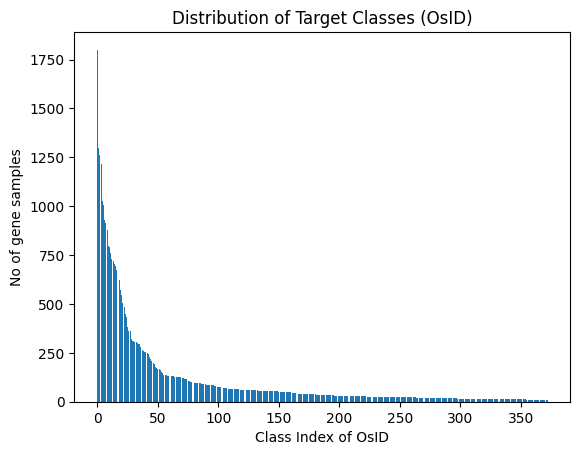

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=80, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Number of input features: 1
Fold: 1
Epoch 1/80
1846/1846 [==============================] - 36s 15ms/step - loss: 5.0776 - accuracy: 0.0423 - val_loss: 5.0040 - val_accuracy: 0.0444
Epoch 2/80
1846/1846 [==============================] - 23s 13ms/step - loss: 4.9421 - accuracy: 0.0451 - val_loss: 4.9984 - val_accuracy: 0.0451
Epoch 3/80
1846/1846 [==============================] - 24s 13ms/step - loss: 4.9314 - accuracy: 0.0443 - val_loss: 4.9925 - val_accuracy: 0.0444
Epoch 4/80
1846/1846 [==============================] - 15s 8ms/step - loss: 4.9304 - accuracy: 0.0450 - val_loss: 4.9944 - val_accuracy: 0.0451
Epoch 5/80
1846/1846 [==============================] - 18s 10ms/step - loss: 4.9280 - accuracy: 0.0454 - val_loss: 4.9986 - val_accuracy: 0.0451
Epoch 6/80
1846/1846 [==============================] - 17s 9ms/step - loss: 4.9263 - accuracy: 0.0454 - val_loss: 5.0013 - val_accuracy: 0.0451
Epoch 7/80
1846/1846 [==============================] - 22s 12ms/step - loss: 4.9241 - acc

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 11s 4ms/step - loss: 5.0818 - accuracy: 0.0416 - val_loss: 5.0194 - val_accuracy: 0.0436
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9248 - accuracy: 0.0489 - val_loss: 4.9436 - val_accuracy: 0.0513
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8446 - accuracy: 0.0538 - val_loss: 4.9241 - val_accuracy: 0.0521
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8089 - accuracy: 0.0551 - val_loss: 4.8936 - val_accuracy: 0.0585
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.7867 - accuracy: 0.0552 - val_loss: 4.9054 - val_accuracy: 0.0554
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.7728 - accuracy: 0.0579 - val_loss: 4.8930 - val_accuracy: 0.0477
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.7579 - accuracy: 0.0582 - val_loss: 4.9201 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 10s 4ms/step - loss: 4.9408 - accuracy: 0.0689 - val_loss: 4.7615 - val_accuracy: 0.0759
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6294 - accuracy: 0.0849 - val_loss: 4.6932 - val_accuracy: 0.0785
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5743 - accuracy: 0.0845 - val_loss: 4.6735 - val_accuracy: 0.0792
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.5485 - accuracy: 0.0847 - val_loss: 4.6643 - val_accuracy: 0.0735
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5302 - accuracy: 0.0848 - val_loss: 4.6499 - val_accuracy: 0.0779
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5150 - accuracy: 0.0845 - val_loss: 4.6532 - val_accuracy: 0.0799
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 4.5029 - accuracy: 0.0854 - val_loss: 4.6479 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 11s 4ms/step - loss: 4.5372 - accuracy: 0.1132 - val_loss: 4.1101 - val_accuracy: 0.1745
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7248 - accuracy: 0.1999 - val_loss: 3.6077 - val_accuracy: 0.2387
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.2285 - accuracy: 0.2691 - val_loss: 3.2638 - val_accuracy: 0.2880
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9146 - accuracy: 0.3090 - val_loss: 3.0239 - val_accuracy: 0.3041
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6907 - accuracy: 0.3386 - val_loss: 2.8339 - val_accuracy: 0.3364
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5227 - accuracy: 0.3675 - val_loss: 2.6955 - val_accuracy: 0.3518
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3951 - accuracy: 0.3879 - val_loss: 2.5608 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 10s 4ms/step - loss: 4.3197 - accuracy: 0.1526 - val_loss: 3.6992 - val_accuracy: 0.2642
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1654 - accuracy: 0.3006 - val_loss: 3.0441 - val_accuracy: 0.3243
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6132 - accuracy: 0.3787 - val_loss: 2.6308 - val_accuracy: 0.4051
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2258 - accuracy: 0.4339 - val_loss: 2.3231 - val_accuracy: 0.4708
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9547 - accuracy: 0.4815 - val_loss: 2.1409 - val_accuracy: 0.4761
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7650 - accuracy: 0.5178 - val_loss: 2.0047 - val_accuracy: 0.5204
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6237 - accuracy: 0.5503 - val_loss: 1.8582 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 3ms/step - loss: 4.0042 - accuracy: 0.2193 - val_loss: 3.0885 - val_accuracy: 0.3393
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3960 - accuracy: 0.4756 - val_loss: 2.2397 - val_accuracy: 0.5133
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6964 - accuracy: 0.5998 - val_loss: 1.7231 - val_accuracy: 0.6290
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2793 - accuracy: 0.6809 - val_loss: 1.4818 - val_accuracy: 0.6876
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0373 - accuracy: 0.7272 - val_loss: 1.2708 - val_accuracy: 0.7206
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8877 - accuracy: 0.7585 - val_loss: 1.1612 - val_accuracy: 0.7567
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8007 - accuracy: 0.7757 - val_loss: 1.0669 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 4.1294 - accuracy: 0.2069 - val_loss: 3.2869 - val_accuracy: 0.3287
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5729 - accuracy: 0.4660 - val_loss: 2.2961 - val_accuracy: 0.5474
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7304 - accuracy: 0.6000 - val_loss: 1.7053 - val_accuracy: 0.6297
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2424 - accuracy: 0.6863 - val_loss: 1.3718 - val_accuracy: 0.6975
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9685 - accuracy: 0.7402 - val_loss: 1.1525 - val_accuracy: 0.7474
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8145 - accuracy: 0.7735 - val_loss: 1.0566 - val_accuracy: 0.7703
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7107 - accuracy: 0.7996 - val_loss: 0.9233 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 4.0729 - accuracy: 0.1791 - val_loss: 3.3074 - val_accuracy: 0.2904
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6916 - accuracy: 0.4255 - val_loss: 2.4469 - val_accuracy: 0.4961
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9717 - accuracy: 0.5592 - val_loss: 1.9282 - val_accuracy: 0.6059
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5551 - accuracy: 0.6396 - val_loss: 1.6530 - val_accuracy: 0.6554
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2866 - accuracy: 0.6887 - val_loss: 1.4039 - val_accuracy: 0.7274
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0812 - accuracy: 0.7250 - val_loss: 1.3067 - val_accuracy: 0.7406
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9373 - accuracy: 0.7549 - val_loss: 1.1587 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 3.7638 - accuracy: 0.2635 - val_loss: 2.7102 - val_accuracy: 0.4667
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9606 - accuracy: 0.6037 - val_loss: 1.6416 - val_accuracy: 0.6948
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2116 - accuracy: 0.7441 - val_loss: 1.2046 - val_accuracy: 0.7688
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8484 - accuracy: 0.8026 - val_loss: 0.9170 - val_accuracy: 0.8238
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6547 - accuracy: 0.8332 - val_loss: 0.8117 - val_accuracy: 0.8398
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5346 - accuracy: 0.8570 - val_loss: 0.7991 - val_accuracy: 0.8152
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4589 - accuracy: 0.8780 - val_loss: 0.6454 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 3ms/step - loss: 4.0324 - accuracy: 0.2089 - val_loss: 3.0997 - val_accuracy: 0.4233
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2446 - accuracy: 0.5764 - val_loss: 1.9347 - val_accuracy: 0.6638
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4108 - accuracy: 0.7181 - val_loss: 1.4267 - val_accuracy: 0.7494
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0150 - accuracy: 0.7879 - val_loss: 1.1235 - val_accuracy: 0.8123
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7802 - accuracy: 0.8267 - val_loss: 0.9493 - val_accuracy: 0.8427
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6229 - accuracy: 0.8570 - val_loss: 0.8173 - val_accuracy: 0.8550
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5181 - accuracy: 0.8763 - val_loss: 0.7257 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 3.7906 - accuracy: 0.2667 - val_loss: 2.6530 - val_accuracy: 0.5254
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8175 - accuracy: 0.6632 - val_loss: 1.5045 - val_accuracy: 0.7454
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0436 - accuracy: 0.7970 - val_loss: 1.0273 - val_accuracy: 0.8244
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6831 - accuracy: 0.8622 - val_loss: 0.7663 - val_accuracy: 0.8625
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4872 - accuracy: 0.8941 - val_loss: 0.6261 - val_accuracy: 0.8970
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3737 - accuracy: 0.9136 - val_loss: 0.6633 - val_accuracy: 0.8805
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3171 - accuracy: 0.9216 - val_loss: 0.5921 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 3ms/step - loss: 3.5792 - accuracy: 0.3112 - val_loss: 2.3980 - val_accuracy: 0.5635
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6140 - accuracy: 0.6954 - val_loss: 1.4032 - val_accuracy: 0.7597
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9022 - accuracy: 0.8175 - val_loss: 0.9536 - val_accuracy: 0.8400
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5867 - accuracy: 0.8719 - val_loss: 0.7681 - val_accuracy: 0.8737
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4372 - accuracy: 0.8984 - val_loss: 0.6180 - val_accuracy: 0.8873
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3471 - accuracy: 0.9142 - val_loss: 0.5315 - val_accuracy: 0.9045
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2963 - accuracy: 0.9223 - val_loss: 0.4683 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 3.4842 - accuracy: 0.3530 - val_loss: 2.2422 - val_accuracy: 0.6438
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4622 - accuracy: 0.7427 - val_loss: 1.2967 - val_accuracy: 0.7919
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8291 - accuracy: 0.8372 - val_loss: 0.8894 - val_accuracy: 0.8568
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5389 - accuracy: 0.8801 - val_loss: 0.6804 - val_accuracy: 0.8904
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3967 - accuracy: 0.9074 - val_loss: 0.5874 - val_accuracy: 0.8898
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3261 - accuracy: 0.9184 - val_loss: 0.5111 - val_accuracy: 0.9122
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2802 - accuracy: 0.9308 - val_loss: 0.4600 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 3ms/step - loss: 3.4079 - accuracy: 0.3693 - val_loss: 2.1367 - val_accuracy: 0.6572
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4201 - accuracy: 0.7336 - val_loss: 1.2512 - val_accuracy: 0.7848
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8242 - accuracy: 0.8374 - val_loss: 0.8680 - val_accuracy: 0.8453
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5398 - accuracy: 0.8837 - val_loss: 0.6958 - val_accuracy: 0.8814
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4041 - accuracy: 0.9042 - val_loss: 0.6490 - val_accuracy: 0.8895
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3200 - accuracy: 0.9248 - val_loss: 0.5074 - val_accuracy: 0.9129
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2720 - accuracy: 0.9333 - val_loss: 0.5298 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5624 - accuracy: 0.3260 - val_loss: 2.3627 - val_accuracy: 0.6128
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6237 - accuracy: 0.7017 - val_loss: 1.3948 - val_accuracy: 0.7727
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9653 - accuracy: 0.8103 - val_loss: 1.0078 - val_accuracy: 0.8420
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6547 - accuracy: 0.8669 - val_loss: 0.7782 - val_accuracy: 0.8880
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4781 - accuracy: 0.8980 - val_loss: 0.7187 - val_accuracy: 0.8737
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3660 - accuracy: 0.9159 - val_loss: 0.5673 - val_accuracy: 0.9171
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2964 - accuracy: 0.9276 - val_loss: 0.5037 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 3.4816 - accuracy: 0.3398 - val_loss: 2.2153 - val_accuracy: 0.6299
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4663 - accuracy: 0.7326 - val_loss: 1.2778 - val_accuracy: 0.7930
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8141 - accuracy: 0.8452 - val_loss: 0.9097 - val_accuracy: 0.8612
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5193 - accuracy: 0.8938 - val_loss: 0.7052 - val_accuracy: 0.8983
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3780 - accuracy: 0.9158 - val_loss: 0.5672 - val_accuracy: 0.9219
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2962 - accuracy: 0.9344 - val_loss: 0.4987 - val_accuracy: 0.9265
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2496 - accuracy: 0.9398 - val_loss: 0.4201 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 3ms/step - loss: 3.1601 - accuracy: 0.4189 - val_loss: 1.7033 - val_accuracy: 0.7041
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.0878 - accuracy: 0.7859 - val_loss: 0.9633 - val_accuracy: 0.8180
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.6241 - accuracy: 0.8607 - val_loss: 0.6875 - val_accuracy: 0.8724
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4413 - accuracy: 0.8900 - val_loss: 0.5956 - val_accuracy: 0.8895
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3547 - accuracy: 0.9087 - val_loss: 0.5514 - val_accuracy: 0.8939
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2916 - accuracy: 0.9237 - val_loss: 0.4259 - val_accuracy: 0.9237
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2605 - accuracy: 0.9299 - val_loss: 0.3996 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 3.3105 - accuracy: 0.3837 - val_loss: 2.0228 - val_accuracy: 0.6480
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2917 - accuracy: 0.7600 - val_loss: 1.1170 - val_accuracy: 0.8145
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7138 - accuracy: 0.8613 - val_loss: 0.7907 - val_accuracy: 0.8561
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4679 - accuracy: 0.8968 - val_loss: 0.6156 - val_accuracy: 0.8873
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3476 - accuracy: 0.9170 - val_loss: 0.5532 - val_accuracy: 0.9129
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2841 - accuracy: 0.9306 - val_loss: 0.4985 - val_accuracy: 0.9096
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2470 - accuracy: 0.9366 - val_loss: 0.4474 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 8s 3ms/step - loss: 3.3210 - accuracy: 0.3845 - val_loss: 2.0549 - val_accuracy: 0.6574
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3258 - accuracy: 0.7600 - val_loss: 1.1775 - val_accuracy: 0.8134
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7230 - accuracy: 0.8571 - val_loss: 0.7904 - val_accuracy: 0.8717
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4736 - accuracy: 0.8952 - val_loss: 0.6453 - val_accuracy: 0.8849
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3534 - accuracy: 0.9164 - val_loss: 0.5335 - val_accuracy: 0.9025
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2974 - accuracy: 0.9223 - val_loss: 0.5037 - val_accuracy: 0.9091
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2541 - accuracy: 0.9354 - val_loss: 0.4366 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 7s 3ms/step - loss: 3.2953 - accuracy: 0.3775 - val_loss: 2.0482 - val_accuracy: 0.6484
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3424 - accuracy: 0.7517 - val_loss: 1.1386 - val_accuracy: 0.8062
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7164 - accuracy: 0.8550 - val_loss: 0.7431 - val_accuracy: 0.8746
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4492 - accuracy: 0.8993 - val_loss: 0.5957 - val_accuracy: 0.8959
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3304 - accuracy: 0.9228 - val_loss: 0.4967 - val_accuracy: 0.9160
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2746 - accuracy: 0.9329 - val_loss: 0.4557 - val_accuracy: 0.9107
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2363 - accuracy: 0.9421 - val_loss: 0.3760 - val_accuracy:

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

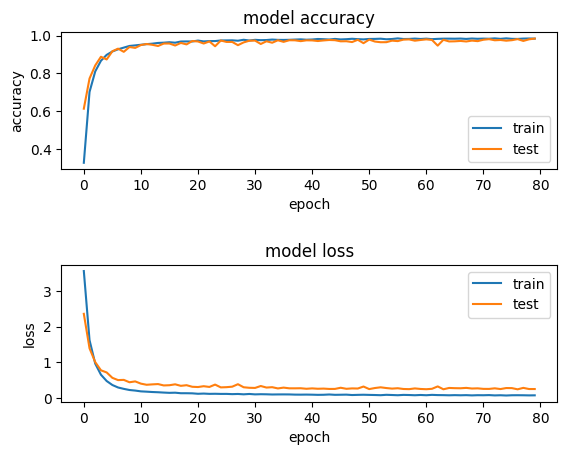

Final Test Accuracy: 0.9885752201080322


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
